# 2. 멋진 단어사전 만들기

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?

- 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?

- SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?

- SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.


In [1]:
from konlpy.tag import Mecab

mecab = Mecab()

## 데이터 다운로드 및 분석

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline


In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


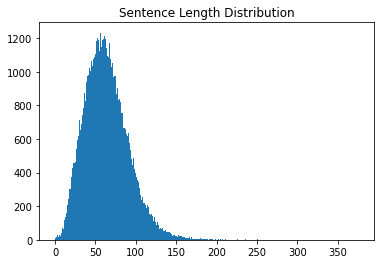

In [4]:
min_len = 1500
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

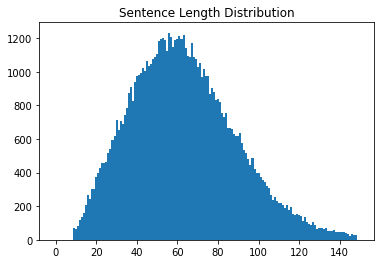

In [5]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 공백 기반 토큰화

In [6]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [7]:
# 정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    # 코드를 작성하세요
    split_corpus.append(kor.split())

In [8]:
# 공백 기간 토큰화 진행한 후 , 단어 사전의 길이 확인 
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [9]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 50: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번
12 : 한
13 : 대해
14 : 것으로
15 : 전
16 : 것이라고
17 : 미국
18 : 있다고
19 : 것을
20 : 중
21 : 미
22 : 그러나
23 : 다른
24 : 더
25 : 이라크
26 : 한편
27 : 많은
28 : 통해
29 : 위한
30 : 대통령은
31 : 가장
32 : 같은
33 : 그의
34 : 이후
35 : 그
36 : 또
37 : 대변인은
38 : 후
39 : 동안
40 : 주장했다.
41 : 것은
42 : 될
43 : 할
44 : 부시
45 : 또한
46 : 것이다.
47 : 보도했다.
48 : 덧붙였다.
49 : 및
50 : 영국
51 : 중국


## 형태소 기반 토큰화

In [10]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))


In [11]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


- tokenizer.sequences_to_texts() 함수를 사용하여 Decoding
- tokenizer.index_word 를 사용하여 Decoding

In [12]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

교착 상태 에 빠진 북 핵 문제 에 대한 6 자 회담 의 참가국 들 은 주말 동안 양자 접촉 과 실무 급 회의 에 전념 하 며 첫 합동 결의문 인 공동 문건 초안 을 놓 고 협의 를 계속 하 여 그 결과 네 차례 의 협상 이 끝날 것 으로 보인다 .


In [13]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "
print(sentence)

교착 상태 에 빠진 북 핵 문제 에 대한 6 자 회담 의 참가국 들 은 주말 동안 양자 접촉 과 실무 급 회의 에 전념 하 며 첫 합동 결의문 인 공동 문건 초안 을 놓 고 협의 를 계속 하 여 그 결과 네 차례 의 협상 이 끝날 것 으로 보인다 . 


## 프로젝트: SentencePiece 사용하기

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

## Step 1. SentencePiece 설치하기

In [70]:
# ! pip install sentencepiece

## Step 2. SentencePiece 모델 학습

In [16]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Jan 16 08:28 korean_spm.model
-rw-r--r-- 1 root root 146213 Jan 16 08:28 korean_spm.vocab


In [17]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Step 3. Tokenizer 함수 작성

In [18]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

In [19]:
import pandas as pd
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [20]:
print(train_data.isnull().values.any())

True


In [21]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [22]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 50000


In [24]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2) 데이터 정제하기

In [25]:
# train_data의 데이터 중복 유무 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

훈련용 리뷰 개수 : 150000 > 중복 제거 후 146182로 줄어듬 
- 중복된 데이터가 4000개 정도 된다.

In [26]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [27]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


### 레이블값의 분포 확인

<AxesSubplot:>

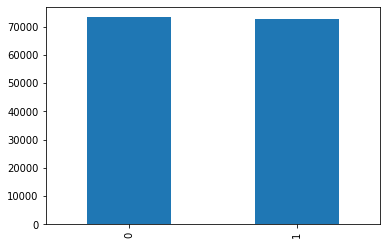

In [28]:
train_data['label'].value_counts().plot(kind = 'bar')

- 그래프 상으로는 약 72,000정도의 데이터가 존재하는걸로 확인된다.

In [29]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [30]:
# NUll값 확인
print(train_data.isnull().values.any())

True


In [31]:
# NUll값이 어떤 열에 존재하는지 확인
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [32]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [33]:
# Null값 제거
train_data = train_data.dropna(how = 'any') 
print(train_data.isnull().values.any()) 

False


In [34]:
print(len(train_data))
# 총 샘플의 수 : 146183 > 1개 줄어듬

146182


In [35]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


## 데이터 전처리
1. 알파벳과 공백 제외 
2. 한글과 공백 제외

In [37]:
import re

eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [38]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]


/tmp/ipykernel_532/3009552299.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [39]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipykernel_532/2260017223.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [40]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [41]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [42]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipykernel_532/3570305079.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_532/3570305079.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


## 토큰화

In [43]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [46]:
from konlpy.tag import Okt
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

- 와 라는 감탄사를 오다 , 가다 의 오다로 인식한다. 
- 나을 뻔 의 의미가 낫다 인데 어떤 의미로 해석한건지?.. 
- 저번에 퍼실님이 컴퓨터는 똑똑해 보여도 사실은 똥멍청이라고 했는데 오늘 또 한 번 느낀다


- 한국어를 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토크화 하는 것이 아니라, 주로 형태소 분석기를 사용한다. 

In [48]:
from tqdm import tqdm
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [10:23<00:00, 233.25it/s]


In [49]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [50]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [03:48<00:00, 214.05it/s]


## 정수 인코딩

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [55]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '고': 44, '아깝다': 45, '더': 46, '배우': 47, '때': 48, 'ㅋㅋ': 49, '아': 50, '감독': 51, '거': 52, '그냥': 53, '재미있다': 54, '요': 55, '재미': 56, '시간': 57, '내용': 58, '뭐': 59, '까지': 60, '중': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '쓰레기': 67, '수': 68, '네': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, '오다': 87, 'ㅋ': 88, 'ㅠㅠ': 89, '많다': 90, '처음': 91, 'ㅋㅋㅋ': 92, '장면': 93, '액션': 94, '주인공': 95, '이렇게': 96, '안되다': 97, '걸': 98, '차다': 99, '나다': 100, '개': 101, '하': 1

In [56]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [57]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [58]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [59]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [60]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거하기

In [61]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [62]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


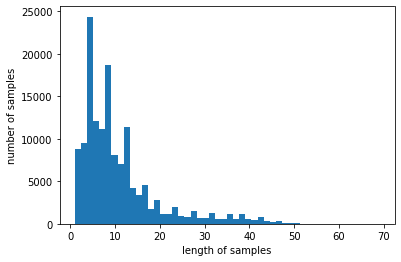

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [66]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [67]:
max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [68]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

##  LSTM으로 네이버 영화 리뷰 감성 분류하기

In [71]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1815/1815 [==============================] - 37s 6ms/step - loss: 0.3881 - acc: 0.8229 - val_loss: 0.3504 - val_acc: 0.8450

Epoch 00001: val_acc improved from -inf to 0.84500, saving model to best_model.h5
Epoch 2/15
1815/1815 [==============================] - 10s 6ms/step - loss: 0.3247 - acc: 0.8594 - val_loss: 0.3357 - val_acc: 0.8540

Epoch 00002: val_acc improved from 0.84500 to 0.85396, saving model to best_model.h5
Epoch 3/15
1815/1815 [==============================] - 11s 6ms/step - loss: 0.2998 - acc: 0.8723 - val_loss: 0.3321 - val_acc: 0.8558

Epoch 00003: val_acc improved from 0.85396 to 0.85578, saving model to best_model.h5
Epoch 4/15
1815/1815 [==============================] - 10s 6ms/step - loss: 0.2812 - acc: 0.8837 - val_loss: 0.3247 - val_acc: 0.8598

Epoch 00004: val_acc improved from 0.85578 to 0.85981, saving model to best_model.h5
Epoch 5/15
1815/1815 [==============================] - 11s 6ms/step - loss: 0.2648 - acc: 0.8918 - val_loss: 0.3309 - 

In [72]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 4s 2ms/step - loss: 0.3304 - acc: 0.8561

 테스트 정확도: 0.8561


In [74]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## 리뷰 예측해보기

In [75]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [76]:
sentiment_predict("영화가 너무 재미없어요")

99.00% 확률로 부정 리뷰입니다.



In [77]:
sentiment_predict("재미는 있는데 별로?")

95.42% 확률로 부정 리뷰입니다.



In [78]:
sentiment_predict("내 스타일은 아닌듯")

87.71% 확률로 부정 리뷰입니다.



In [79]:
sentiment_predict("와 재밌다 ^^!")

87.87% 확률로 긍정 리뷰입니다.



In [80]:
sentiment_predict("와 재밌다 ^^")

87.87% 확률로 긍정 리뷰입니다.



- sentiment_predict("와 재밌다 ^^!") > 이거는 살짝 비꼼의 의미를 캐치할 수 있나 궁금해서 출력했는데 역시나 구별하지 못하는 듯
- 텍스트 데이터 다루기에서 얘기 했던 내용이 생각나서 한 번 해봤당

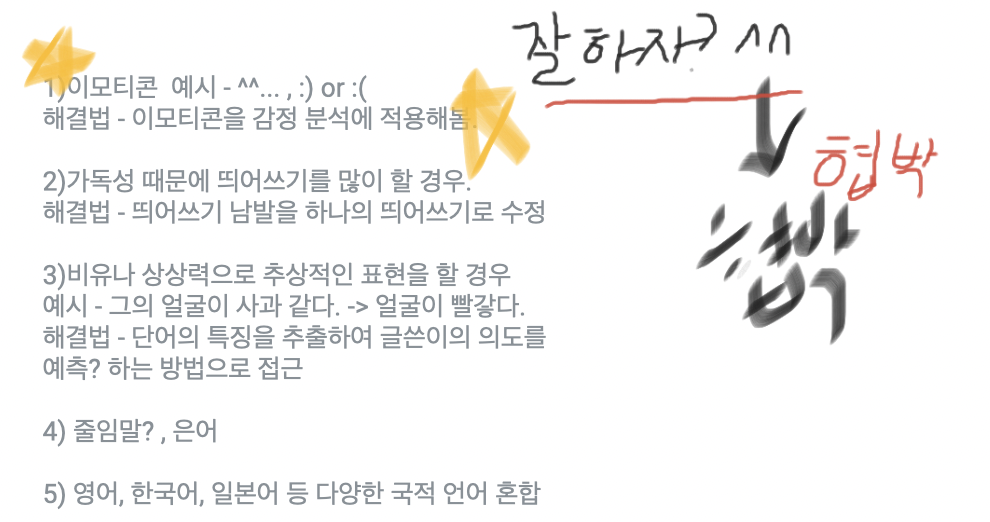

# 회고 
https://wikidocs.net/44249 와 노드를 참고하여 작성하였습니다.